# Step 1: Define Problem

### What need to do
In this notebook, we are going build a model to classify news into categories. The text in the data was giving is in english format.

### Why
We do this because, we want to sort the unseen news into groups, for that the users or the readers can easily asset to the news easily with search. Also for the news manager.

### How to do
There are two methods that use in this project: NLP, Machine Learning

We use NLP to preprocessing text data into clean and readable for machine

We use Machine Learning to build a model to learning classify text input data 




# Step 2: Data Understanding

In [1]:
import pandas as pd


## Reading data

In [2]:
train_df = pd.read_csv('dataset/BBC News Train.csv')
test_df = pd.read_csv('dataset/BBC News Test.csv')

print(f"Training data shape:{train_df.shape}")
print(f"Test data shape:{test_df.shape}")

train_df.head()

Training data shape:(1490, 3)
Test data shape:(735, 2)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


## Understanding target "Category" 

In [4]:
train_df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

These are five categories of news. In general, these 5 categories can be covers almost the news we read. So these are no worry about, that some text that not in these category. 

Also the data is balance. Let's go detail in each category.

In [5]:
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
additional_stopwords = ['said']
STOPWORDS = set(nltk.corpus.stopwords.words('english') + additional_stopwords)
f"Stopwords length: {len(STOPWORDS)}"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Stopwords length: 180'

In [6]:
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=STOPWORDS, max_words=200, background_color='white', max_font_size=60).generate(text)
    plt.figure(figsize=(13,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

### Word Cloud

Word Cloud for business news:


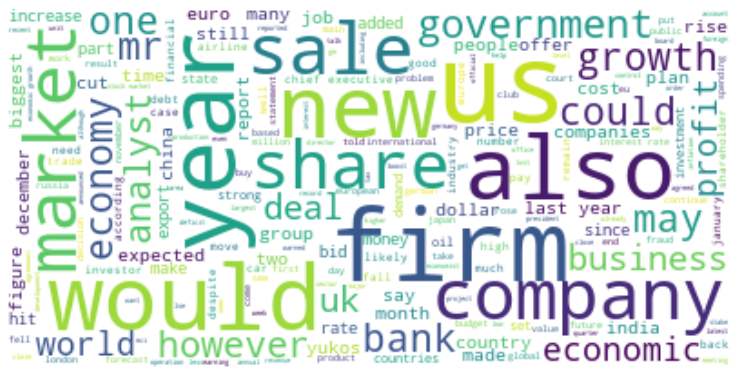

Word Cloud for tech news:


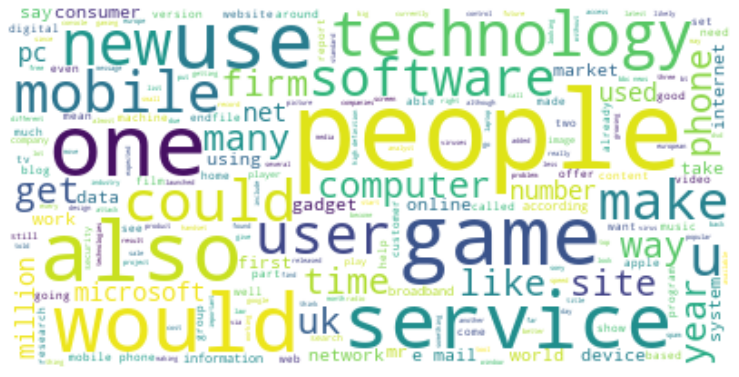

Word Cloud for politics news:


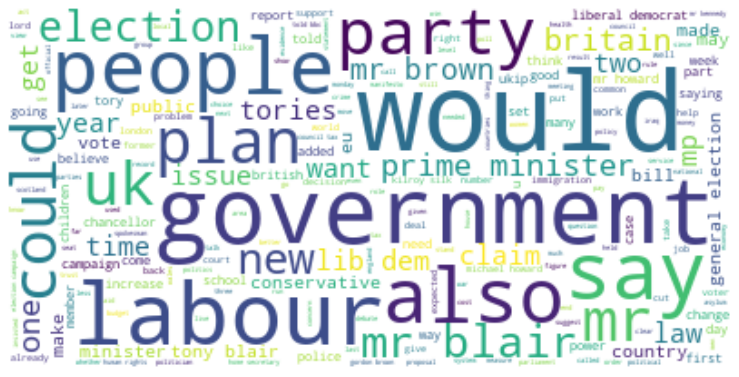

Word Cloud for sport news:


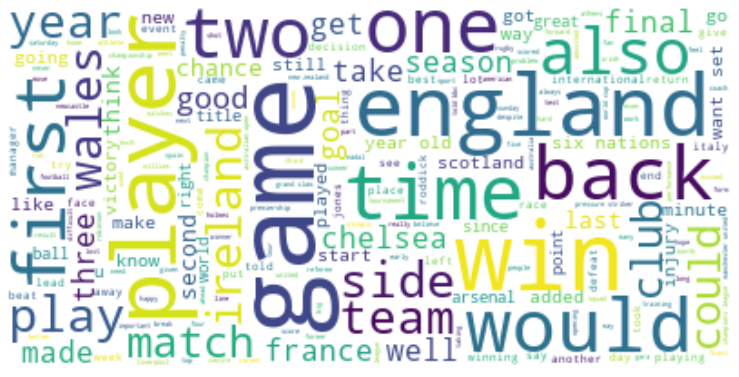

Word Cloud for entertainment news:


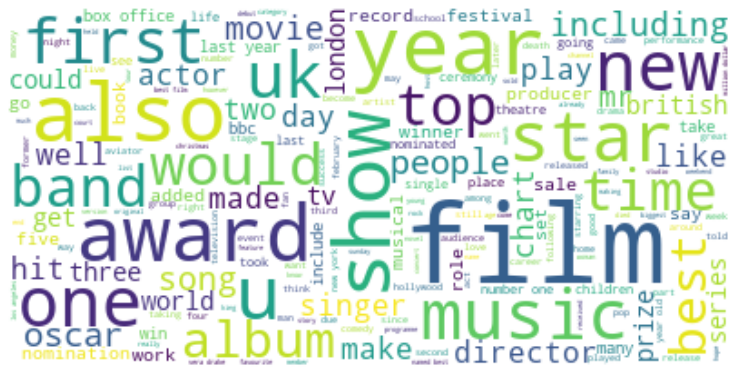

In [7]:
possible_target = list(train_df['Category'].unique())

for category in possible_target:
    big_str = train_df.loc[train_df.Category == category, 'Text']
    big_str = ' '.join(big_str.values)
    print("====="*10)
    print(f"Word Cloud for {category} news:")
    generate_wordcloud(big_str)

## Understanding Text Feature

In [20]:
import spacy
print(f"Spacy version: {spacy.__version__}")

nlp_spacy = spacy.load('en_core_web_sm')
#Adding stopwords
nlp_spacy.Defaults.stop_words |= {"said","say", "saying", 'says', 'will', 'also', 'would', 'could', 'can'}
nlp_spacy

Spacy version: 2.1.4


In [10]:
%%time
simple_report = {'is_word_count': 0, 'is_not_word_count': 0, 
                 'is_stop_count': 0, 'is_punct_count' : 0, 'is_digit_count' : 0, 'is_currency_count' : 0,
                 'is_url_count': 0, 'is_PROPN_count': 0, 'is_email_count': 0}

for text in train_df['Text'].values:
    doc = nlp_spacy(text)
    for token in doc:
        simple_report['is_word_count'] += token.is_alpha
        simple_report['is_not_word_count'] += not token.is_alpha
        simple_report['is_stop_count'] += token.is_stop
        simple_report['is_punct_count'] += token.is_punct
        simple_report['is_digit_count'] += token.like_num
        simple_report['is_currency_count'] += token.is_currency
        simple_report['is_url_count'] += token.like_url
        simple_report['is_email_count'] += token.like_email
        simple_report['is_PROPN_count'] += token.pos_ == 'PROPN'

Wall time: 1min 13s


In [ ]:
df_simple_report = pd.DataFrame([simple_report])
df_simple_report.T

,0
is_word_count,565533
is_not_word_count,95107
is_stop_count,266954
is_punct_count,41194
is_digit_count,15136
is_currency_count,1732
is_url_count,62
is_PROPN_count,1540
is_email_count,0


In [ ]:
ner_labels = nlp_spacy.get_pipe("ner").labels
for label in ner_labels:
    print(label, spacy.explain(label))

QUANTITY Measurements, as of weight or distance
EVENT Named hurricanes, battles, wars, sports events, etc.
PERSON People, including fictional
DATE Absolute or relative dates or periods
FAC Buildings, airports, highways, bridges, etc.
LAW Named documents made into laws.
LANGUAGE Any named language
TIME Times smaller than a day
CARDINAL Numerals that do not fall under another type
MONEY Monetary values, including unit
LOC Non-GPE locations, mountain ranges, bodies of water
NORP Nationalities or religious or political groups
ORDINAL "first", "second", etc.
PRODUCT Objects, vehicles, foods, etc. (not services)
PERCENT Percentage, including "%"
ORG Companies, agencies, institutions, etc.
GPE Countries, cities, states
WORK_OF_ART Titles of books, songs, etc.


In [ ]:
%%time
category_report = {}

for category in possible_target:
    category_news = train_df.loc[train_df.Category == category, 'Text'].values
    report = {'is_currency_count' : 0,'is_url_count': 0, 'is_GPE_count': 0,
                'is_PERSON_count': 0, 'is_ORDINAL_count': 0, 'is_LOC_count': 0,
                 'is_TIME_count':0,'is_QUANTITY_count': 0, 'is_PRODUCT_count': 0, 'is_ORG_count': 0}
    for new in category_news:
        doc = nlp_spacy(new)
        for token in doc:
            report['is_currency_count'] += token.is_currency
            report['is_url_count'] += token.like_url
            report['is_PERSON_count'] += token.ent_type_ == 'PERSON'
            report['is_GPE_count'] += token.ent_type_ == 'GPE'
            report['is_ORDINAL_count'] += token.ent_type_ == 'ORDINAL'
            report['is_LOC_count'] += token.ent_type_ == 'LOC'
            report['is_TIME_count'] += token.ent_type_ == 'TIME'
            report['is_QUANTITY_count'] += token.ent_type_ == 'QUANTITY'
            report['is_PRODUCT_count'] += token.ent_type_ == 'PRODUCT'
            report['is_ORG_count'] += token.ent_type_ == 'ORG'
    category_report[category] = report

Wall time: 1min 8s


In [ ]:
df_category_report = pd.DataFrame()

for category, report in category_report.items():
    for key, value in report.items():
        df_category_report.loc[category, key] = value
        
df_category_report.T

,business,tech,politics,sport,entertainment
is_currency_count,865.0,189.0,274.0,44.0,360.0
is_url_count,2.0,54.0,0.0,1.0,5.0
is_GPE_count,19.0,11.0,1.0,2.0,3.0
is_PERSON_count,19.0,6.0,3.0,6.0,19.0
is_ORDINAL_count,189.0,259.0,221.0,655.0,343.0
is_LOC_count,1.0,6.0,0.0,0.0,1.0
is_TIME_count,106.0,224.0,182.0,604.0,243.0
is_QUANTITY_count,147.0,206.0,66.0,184.0,102.0
is_PRODUCT_count,2.0,7.0,0.0,0.0,3.0
is_ORG_count,31.0,8.0,12.0,5.0,2.0


# Step 3: Data Cleaning, Creating, Correcting

In [21]:
from spellchecker import SpellChecker
from autocorrect import Speller
 
def correct_spelling(text):
    spell = Speller(lang='en')
    return spell.autocorrect_sentence(text)
    #return ' '.join([spell.correction(word) for word in text.split()])

def clean_text(text):
    #text = correct_spelling(text)
    
    doc = nlp_spacy(text)
    
    clean_bag_words = []
    for token in doc:
        if not (token.is_stop or token.like_url or token.is_punct or token.is_space):
            if token.is_currency:
                clean_bag_words.append('_currency_')
            elif token.ent_type_ == 'ORDINAL':
                clean_bag_words.append('_ordinal_')
            elif token.ent_type_ == 'TIME':
                clean_bag_words.append('_time_')
            elif token.ent_type_ == 'QUANTITY':
                clean_bag_words.append('_quantity_')
            else:
                if token.is_alpha and len(token.text) > 2:
                    clean_bag_words.append(token.lemma_)
    
    return clean_bag_words
    

In [22]:
print(clean_text(train_df.loc[0, 'Text']))

['worldcom', 'boss', 'launch', 'defence', 'lawyer', 'defend', 'worldcom', 'chief', 'bernie', 'ebber', 'battery', 'fraud', 'charge', 'call', 'company', 'whistleblower', 'witness', 'cynthia', 'cooper', 'worldcom', 'head', 'internal', 'accounting', 'alert', 'director', 'irregular', 'accounting', 'practice', 'telecom', 'giant', 'warning', 'lead', 'collapse', 'firm', 'follow', 'discovery', '_currency_', '_currency_', 'accounting', 'fraud', 'ebber', 'plead', 'guilty', 'charge', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argue', 'ebber', 'orchestrate', 'series', 'accounting', 'trick', 'worldcom', 'order', 'employee', 'hide', 'expense', 'inflate', 'revenue', 'meet', 'wall', 'street', 'earning', 'estimate', 'cooper', 'run', 'consulting', 'business', 'tell', 'jury', 'new', 'york', 'wednesday', 'external', 'auditor', 'arthur', 'andersen', 'approve', 'worldcom', 'account', 'early', 'andersen', 'give', 'green', 'light', 'procedure', 'practice', 'worldcom', 'ebber', 'lawyer', 'unaware', 'fraud

## Creating corpus vocabulary

In [14]:
from tqdm.contrib.concurrent import thread_map

In [23]:
%%time
#Apply text cleaning to train_df
train_df['CleanText'] =  thread_map(clean_text, train_df.Text.values)

100%|██████████| 1490/1490 [00:49<00:00, 30.31it/s]

Wall time: 49.3 s


In [26]:
train_df.head()

,ArticleId,Text,Category,CleanText
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, boss, launch, defence, lawyer, defe..."
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicate, economic, gloom, citizen..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, govern, mobile, choice, faster, be..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, boss, _currency_, payout, eighteen, en..."


In [27]:
from collections import Counter

#Get big bagwords
big_bag_words  = []
for bag_words in train_df.CleanText.values:
    big_bag_words.extend(bag_words)    
print(f"Big bag words size {len(big_bag_words)}")

#Count words in big_bag_words, get vocabulary corpus
words = Counter(big_bag_words)

print(f"Total unique word in corpus: {len(words.keys())}")
print(f"Top 10 common words: {words.most_common(10)}")
print(f"Top 10 uncommon words: {words.most_common()[-10:-1]}")


Big bag words size 280898
Total unique word in corpus: 18031
Top 10 common words: [('year', 1951), ('_currency_', 1732), ('new', 1352), ('people', 1324), ('time', 1071), ('win', 1063), ('good', 1060), ('game', 966), ('_time_', 945), ('film', 846)]
Top 10 uncommon words: [('grandma', 1), ('plump', 1), ('verbalicious', 1), ('stereophonic', 1), ('rapport', 1), ('wharf', 1), ('glocer', 1), ('unwelcome', 1), ('randomly', 1)]


In [28]:
#Save vocabulary
with open('corpus/vocabulary.txt', 'w', encoding='utf-8') as f:
    for word, count in words.most_common():
        f.write(f'{word}, {count}\n')
        


In [29]:
#Save train_df
train_df.to_csv('corpus/clean_training_set.csv', index=False)